<b>Disclaimer:</b> I didn't filtered out nor cleaned that much this notebook, indeed, I only divided it in sections but I didn't put many comments. I also presented only the code of the things I presented in the final report

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.metrics import silhouette_score, silhouette_samples

df = pd.read_csv("dataset.csv")

<b>Preprocessing</b> (See the data understanding and preparation notebook) 

In [2]:
#fill missing values and fix upcase letters
df = df.sort_values(by='familiarity')
df.reset_index(drop=True, inplace=True)
miss_vals = dict(df['web_corpus_freq'].isna())
check_val = []
for x in miss_vals:
    if miss_vals[x] == True:
        check_val.append(x)
        #substitute the missing values with the mean values at the previous and following index
        df.loc[x, 'web_corpus_freq'] = (df['web_corpus_freq'].iloc[x-1]+df['web_corpus_freq'].iloc[x+1])/2
        #fix the uppercase letters
        df.loc[x, 'word'] = df['word'].iloc[x].lower()
df = df.sort_values(by='word') 
df.reset_index(drop=True, inplace=True)

#log transformation of web corpus
df['web_corpus_freq'] = np.log(df['web_corpus_freq'])
df = df.rename({'web_corpus_freq' : 'log_web_corpus_freq'}, axis='columns')

df_bckp = df.copy(deep=True)
raw = df.drop(columns=['word', 'polysemy', 'length'])

#rescaling the features
X = raw.values
minmax = MinMaxScaler()
X_scaled = minmax.fit_transform(X)

#pca with three components as I enstablished in the data understanding and preparation part
pca = PCA(n_components=3)
x_new = pca.fit_transform(X_scaled)

#rename the columns with "PCx" and save them into a dataframe
df_pca = pd.DataFrame(x_new, columns=['PC'+str(i) for i in range(1, pca.n_components_+1)])

<b>KMEANS</b>

In [3]:
sse_list = []
silhouette_list = []

for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(x_new)
    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(x_new, kmeans.labels_))

Text(0.5, 1.0, 'Silhouette Score Curve')

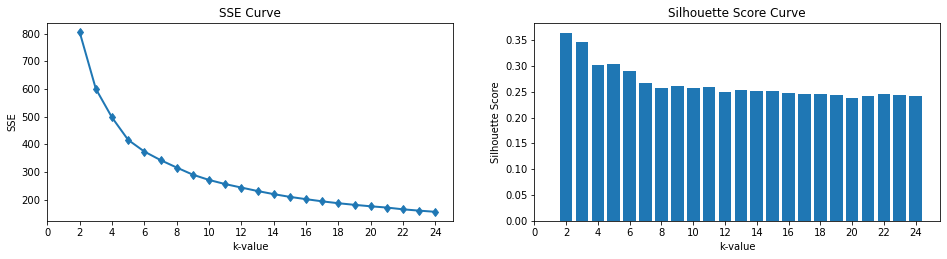

In [4]:
plt.figure(figsize=(16, 8))
fig_dims = (2, 2)

plt.subplot2grid(fig_dims, (0, 0))
plt.plot(range(2, len(sse_list)+2), sse_list, marker='d', linewidth=2)
plt.ylabel('SSE')
plt.xlabel('k-value')
plt.xticks(np.arange(0, len(sse_list)+2, 2.0))
plt.title("SSE Curve")

plt.subplot2grid(fig_dims, (0, 1))
plt.bar(range(2, len(silhouette_list)+2), silhouette_list)
plt.ylabel('Silhouette Score')
plt.xlabel('k-value')
plt.xticks(np.arange(0, len(silhouette_list)+2, 2.0))
plt.title("Silhouette Score Curve")

In [5]:
kmeans = KMeans(n_clusters=5, n_init=10, max_iter=100)
kmeans.fit(x_new)
centroids = kmeans.cluster_centers_
clusters = kmeans.labels_
inertia = kmeans.inertia_

print("SSE:", inertia)

SSE: 416.0728421714981


In [6]:
#Here I turn back the centroids the correspective coordinates in the original data
centers_pca_reverse = pca.inverse_transform(centroids)
centers_minmax_reverse = minmax.inverse_transform(centers_pca_reverse)
centers_origin = pd.DataFrame(centers_minmax_reverse, columns=raw.columns)

#Here I store in the original dataframe the clustering results
df['clusters'] = clusters

In [7]:
def find_nearest(pts, pt):
    x, y = pt
    offset = 0.04 #just because the nearest point to one centroid for the PAIR PC1/PC2 is not captured by that cluster
    lista_valori = []
    for punto_array in pts:
        r, q = punto_array
        valore = ((x - r - offset)**2 + (y - q - offset)**2)**0.5
        lista_valori.append(valore)
    idx = np.array(lista_valori).argmin() #gives the index of the nearest point to pt in pts 
    return idx

representative_pts = []
for x in range(len(centroids)):
    nearest_value = find_nearest( df_pca.values[:,0:2].tolist(), centroids[x][:-1].tolist() )
    representative_pts.append(nearest_value) #the indexes of the almost nearest point to the centroids

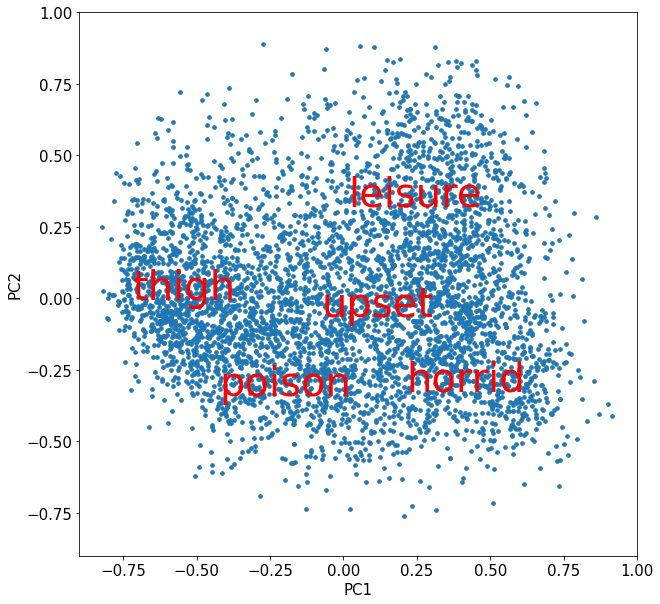

In [8]:
def plot_kmeans_w_centroids(score, coeff):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0
    scaley = 1.0
    plt.figure(figsize=(10, 10))
    plt.scatter(xs * scalex,ys * scaley, s=13)
    plt.ylim(-0.9,1)
    plt.xlim(-0.9,1)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("PC{}".format(1), fontsize=15)
    plt.ylabel("PC{}".format(2), fontsize=15)

#Calling the function I used the first two PC
plot_kmeans_w_centroids(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
for x in representative_pts:
    plt.text(df_pca['PC1'][x], df_pca['PC2'][x], df['word'][x], color = 'r', ha = 'center', va = 'center', fontsize=40)
plt.show()

In [9]:
rappresent = df.loc[representative_pts].drop(columns=[i for i in df.columns if i not in ['word', 'clusters']])
rappresent

word  clusters
4198    thigh         0
3160   poison         1
2075   horrid         2
4410    upset         3
2400  leisure         4

In [10]:
#a roundabout and inefficient but fast way to set the colors and names of the clusters (nothing better came to me at the time)

color_map = {rappresent[rappresent['word'] == 'upset']['clusters'].values[0] : "#fde725", 
             rappresent[rappresent['word'] == 'leisure']['clusters'].values[0]: "#5ec962", 
             rappresent[rappresent['word'] == 'horrid']['clusters'].values[0]: "#3b528b", 
             rappresent[rappresent['word'] == 'poison']['clusters'].values[0]: "#21918c", 
             rappresent[rappresent['word'] == 'thigh']['clusters'].values[0]: "#440154"} #to keep these colors

eng_color = {"#fde725": "yellow", 
             "#5ec962" : "green", 
             "#3b528b" : "blue", 
             "#21918c" : "cyan",
             "#440154" : "violet"}

name_cluster = {"yellow" : "C", 
             "green" : "E", 
             "blue" : "A", 
             "cyan" : "D",
             "violet" : "B"}

color_kmeans_mapped = [color_map.get(number, number) for number in df['clusters']]
eng_c_mapped = [eng_color.get(number, number) for number in color_kmeans_mapped]
name_cluster_mapped = [name_cluster.get(number, number) for number in eng_c_mapped]
df['color_map'] = color_kmeans_mapped
df['eng_color'] = eng_c_mapped
df['name_cluster'] = name_cluster_mapped

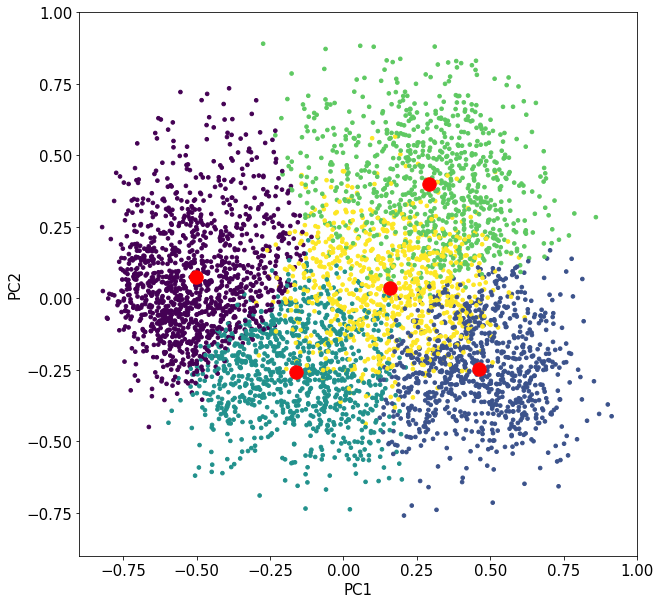

In [11]:
def plot_kmeans_w_centroids(score, coeff):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0
    scaley = 1.0
    plt.figure(figsize=(10, 10))
    plt.scatter(xs * scalex,ys * scaley, c=df['color_map'], s=13)
    plt.scatter(centroids[:,0], centroids[:,1], c='r', marker='o', s=180)
    plt.ylim(-0.9,1)
    plt.xlim(-0.9,1)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("PC{}".format(1), fontsize=15)
    plt.ylabel("PC{}".format(2), fontsize=15)

#Calling the function I used the first two PC
plot_kmeans_w_centroids(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

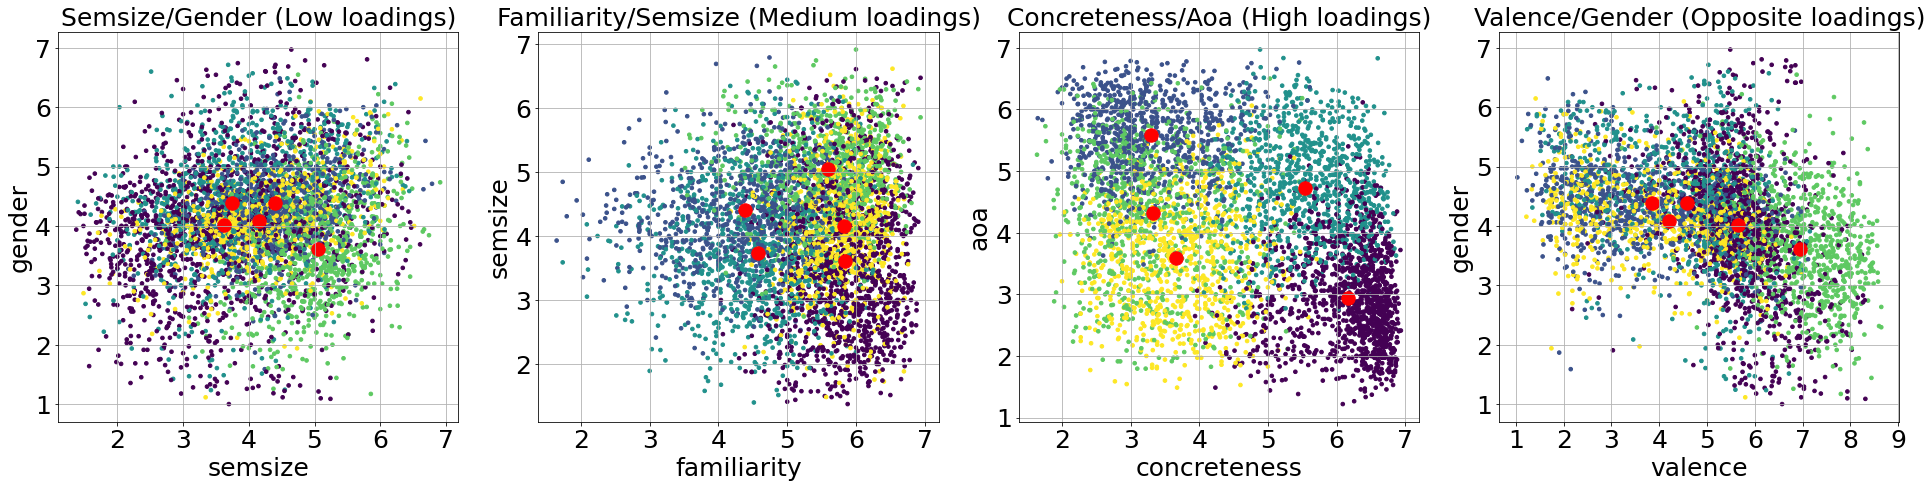

In [12]:
pair_list = {(0, 'Low') : ['semsize', 'gender'], 
             (1, 'Medium') : ['familiarity', 'semsize'], 
             (2, 'High') : ['concreteness', 'aoa'], 
             (3, 'Opposite') : ['valence', 'gender']}

fig = plt.figure(figsize=(33, 33)) 
fig_dims = (4, 4)

for key, pairs in pair_list.items():
    tit = pairs[0][0].upper() + pairs[0][1:] + "/" + pairs[1][0].upper() + pairs[1][1:] + " (" + key[1] + " loadings)"
    plt.subplot2grid(fig_dims, (0, key[0]))
    plt.scatter(df[pairs[0]], df[pairs[1]], c=df['color_map'], s=13)
    plt.scatter(centers_origin[pairs[0]], centers_origin[pairs[1]], c='r', marker='o', s=180)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel(pairs[0], fontsize=25)
    plt.ylabel(pairs[1], fontsize=25)
    plt.title(tit, fontsize=25)
    plt.grid()

In [13]:
print("Polysemous words per cluster count:")
for num in range(0, 5):
    color = df['eng_color'].unique()[num]
    print(df[df['eng_color'] == color]['name_cluster'].unique(), " - ", color, " - polysemy count: ",
         df[df['eng_color'] == color]['polysemy'].value_counts()[1])

Polysemous words per cluster count:
['A']  -  blue  - polysemy count:  14
['D']  -  cyan  - polysemy count:  62
['E']  -  green  - polysemy count:  31
['C']  -  yellow  - polysemy count:  97
['B']  -  violet  - polysemy count:  175


In [14]:
print("Element per cluster count:")
for num in range(0, 5):
    color = df['eng_color'].unique()[num]
    print(df[df['eng_color'] == color]['name_cluster'].unique(), " - ", color, " - count: ",
         df[df['eng_color'] == color]['name_cluster'].value_counts()[0])

Element per cluster count:
['A']  -  blue  - count:  854
['D']  -  cyan  - count:  938
['E']  -  green  - count:  837
['C']  -  yellow  - count:  829
['B']  -  violet  - count:  1224


In [15]:
SSE = []
for i in range(5):
    cluster_singolo = df[df['clusters'] == i].drop(columns=(['word', 'length', 'polysemy', 'clusters', 'color_map', 'eng_color', 'name_cluster']))
    sommatoria_di_cluster = []
    for col in cluster_singolo.columns:
        mi = cluster_singolo[col].mean()
        differenza_elevata = []
        for x in cluster_singolo[col]:
            differenza_elevata.append((x - mi)**2)
        sommatoria = sum(differenza_elevata)
        sommatoria_di_cluster.append(sommatoria)
    SSE.append(sommatoria_di_cluster)

In [16]:
SSE = np.asarray(SSE)
SSE_sum_x_features = sum(SSE)
SSE_sum_x_cluster = sum(SSE.T)
SSE_tot = sum(sum(SSE))

In [17]:
df_x_sse = df.drop(columns=['word', 'length', 'polysemy', 'color_map', 'eng_color'])
cluster_ordinati = []
for i in range(5):
    cluster_ordinati.append(df_x_sse.values[:,-2:][df_x_sse.values[:,-2] == i][0][1])

In [18]:
SSE_df = pd.DataFrame(SSE, columns=([col for col in df_x_sse.columns if col not in ['clusters', 'name_cluster']]))
#SSE_df.insert(0, "cluster", [0,1,2,3,4])
SSE_df.insert(0, "cluster", cluster_ordinati)
SSE_df["tot_cluster"] = SSE_sum_x_cluster
SSE_df = SSE_df.append(SSE_df.sum(numeric_only=True), ignore_index=True)
SSE_df_kmeans = SSE_df.drop(columns=[col for col in SSE_df.columns if col not in ['cluster', 'tot_cluster']])
SSE_df_kmeans

cluster   tot_cluster
0       B  10415.411013
1       D   8282.848108
2       A   7478.268500
3       C   7805.495040
4       E   7218.046187
5     NaN  41200.068848

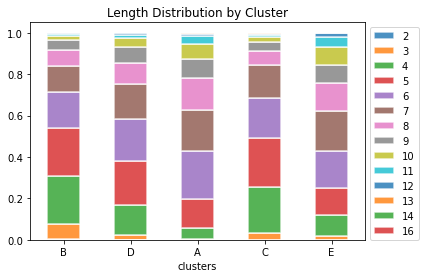

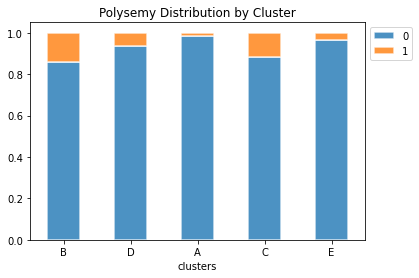

In [19]:
bar_pl = df['length'].groupby(df['clusters']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)
plt.legend(bbox_to_anchor=(1,1))
plt.title("Length Distribution by Cluster")
plt.xticks([0,1,2,3,4], cluster_ordinati, rotation=0)
plt.show()

bar_pl = df['polysemy'].groupby(df['clusters']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)
plt.legend(bbox_to_anchor=(1,1))
plt.title("Polysemy Distribution by Cluster")
plt.xticks([0,1,2,3,4], cluster_ordinati, rotation=0)
plt.show()

In [20]:
df_post_kmeans = df.copy(deep=True)
df = df_bckp.copy(deep=True)

<b>DBSCAN</b>

In [21]:
metrica = 'euclidean'
distanza = squareform(pdist(x_new, metrica))

k = 8
kth_distances = []
for dist in distanza:
    index_kth_dist = np.argsort(dist)[k]
    kth_distances.append(dist[index_kth_dist])

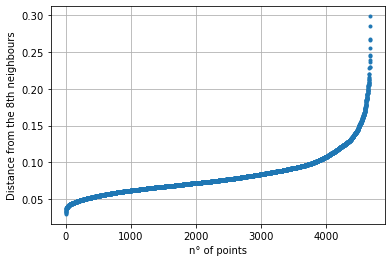

In [22]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances), marker='.', linewidth=0)
plt.ylabel('Distance from the 8th neighbours')
plt.xlabel('n° of points')
plt.grid()

In [23]:
len(kth_distances)-(sorted([round(x, 3) for x in sorted(kth_distances)])[::-1].index(0.125)+1)

4306

Text(0.5, 1.0, 'DBSCAN results on Arousal/Valence')

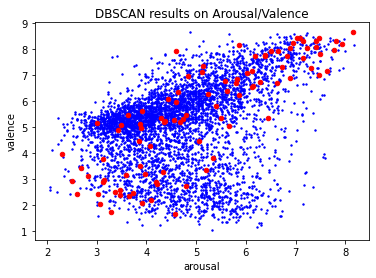

In [24]:
epsilon = 0.125
dbscan = DBSCAN( eps=epsilon, min_samples=k, metric= metrica)
dbscan.fit(x_new)
df['DBSClusters'] = dbscan.labels_
vals = df['DBSClusters'].unique()

x = 'arousal'
y = 'valence'
for val in vals:
    if val == 0:
        df_val = df[df['DBSClusters']==val]
        plt.scatter(df_val[x], df_val[y], s=2, c='blue', zorder=0)
    else:
        df_val = df[df['DBSClusters']==val]
        plt.scatter(df_val[x], df_val[y], s=20, c='red', zorder=5)
plt.xlabel(x)
plt.ylabel(y)
plt.title("DBSCAN results on Arousal/Valence")

In [25]:
df[df['DBSClusters'] == -1]["word"].values

array(['abattoir', 'abstract', 'all', 'banal', 'beautiful', 'belfry',
       'captivating', 'celebration', 'champion', 'conceptual',
       'connoisseur', 'cry', 'cut', 'dandruff', 'dead', 'debtor',
       'dejected', 'destiny', 'diploma', 'dirt', 'dogma', 'edifice',
       'elated', 'emancipation', 'embrace', 'euphoria', 'ever', 'faeces',
       'fate', 'feudalism', 'fireworks', 'flatulent', 'foible',
       'fortuitous', 'free', 'fun', 'gaiety', 'good', 'graduate',
       'graduation', 'grey', 'habituate', 'happy', 'harpsichord', 'have',
       'home', 'imam', 'impossible', 'impropriety', 'infinite',
       'intercourse', 'jacuzzi', 'jubilant', 'laugh', 'leprosy', 'life',
       'love', 'maggot', 'meagre', 'miser', 'morality', 'mum', 'music',
       'name', 'need', 'new', 'open', 'orgasm', 'penthouse', 'phenomenal',
       'phenomenon', 'philosophy', 'please', 'prosperity', 'puke',
       'putrid', 'quiescent', 'rheumatism', 'romanticize', 'savant',
       'scurvy', 'small', 'smile',

In [26]:
df_post_dbscan = df.copy(deep=True)
df = df_bckp.copy(deep=True)

<b>HIERARCHICAL</b>

Text(0.5, 1.0, "Ward's method Linkage")

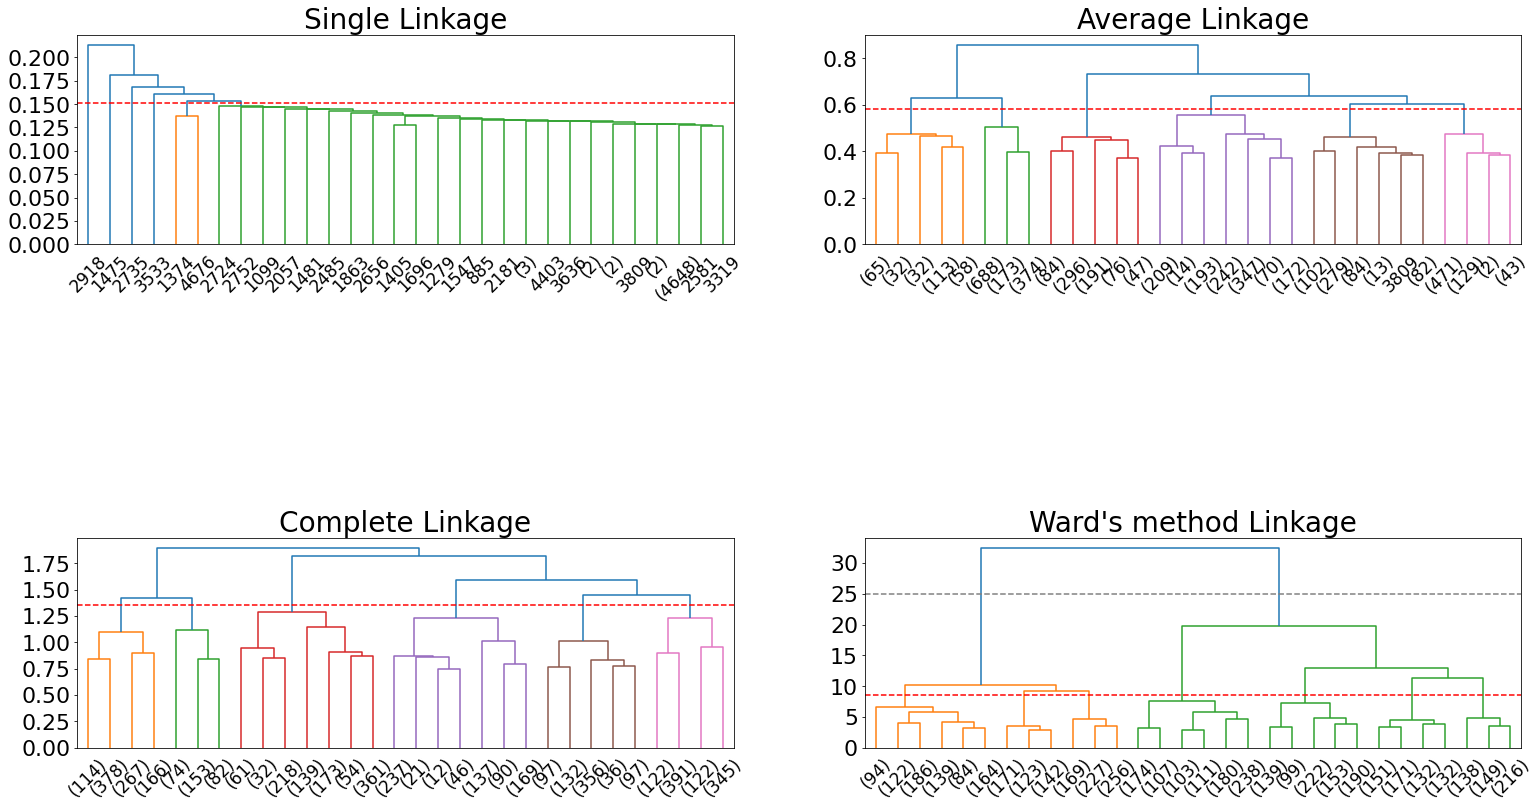

In [27]:
fig = plt.figure(figsize=(40, 27)) 
fig_dims = (6,3)


plt.subplot2grid(fig_dims, (0, 0))
data_dist = pdist(x_new, metric='euclidean')
data_link = linkage(data_dist, method='single')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=0.151, color='r', linestyle='--')
plt.xticks(fontsize=17)
plt.yticks(fontsize=22)
plt.title('Single Linkage', fontsize=28)

plt.subplot2grid(fig_dims, (0, 1))
data_dist = pdist(x_new, metric='euclidean')
data_link = linkage(data_dist, method='average')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=0.58, color='r', linestyle='--')
plt.xticks(fontsize=17)
plt.yticks(fontsize=22)
plt.title('Average Linkage', fontsize=28)

plt.subplot2grid(fig_dims, (2, 0))
data_dist = pdist(x_new, metric='euclidean')
data_link = linkage(data_dist, method='complete')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=1.35, color='r', linestyle='--')
plt.xticks(fontsize=17)
plt.yticks(fontsize=22)
plt.title('Complete Linkage', fontsize=28)

plt.subplot2grid(fig_dims, (2, 1))
data_dist = pdist(x_new, metric='euclidean')
data_link = linkage(data_dist, method='ward')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=8.5, color='r', linestyle='--')
plt.axhline(y=25, color='gray', linestyle='--')
plt.xticks(fontsize=17)
plt.yticks(fontsize=22)
plt.title('Ward\'s method Linkage', fontsize=28)

Text(0.5, 1.0, 'Average Linkage')

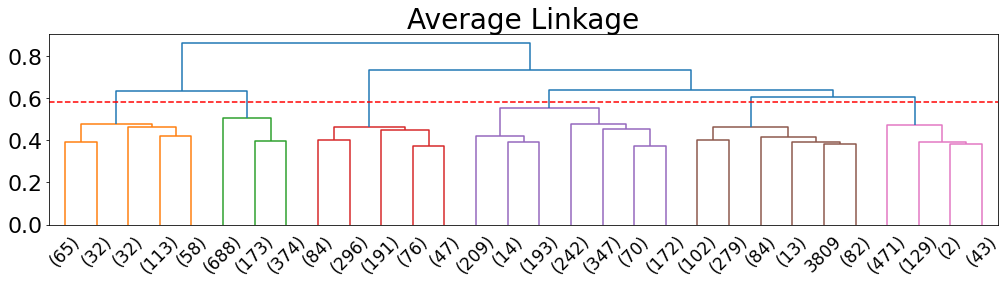

In [28]:
plt.figure(figsize=(17, 3.5)) 
data_dist = pdist(x_new, metric='euclidean')
data_link = linkage(data_dist, method='average')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=0.58, color='r', linestyle='--')
plt.xticks(fontsize=17)
plt.yticks(fontsize=22)
plt.title('Average Linkage', fontsize=28)

In [29]:
#I select this pair to visualize the data because of the high loadings on the PCA
axis_x = 'concreteness'
axis_y = 'aoa'

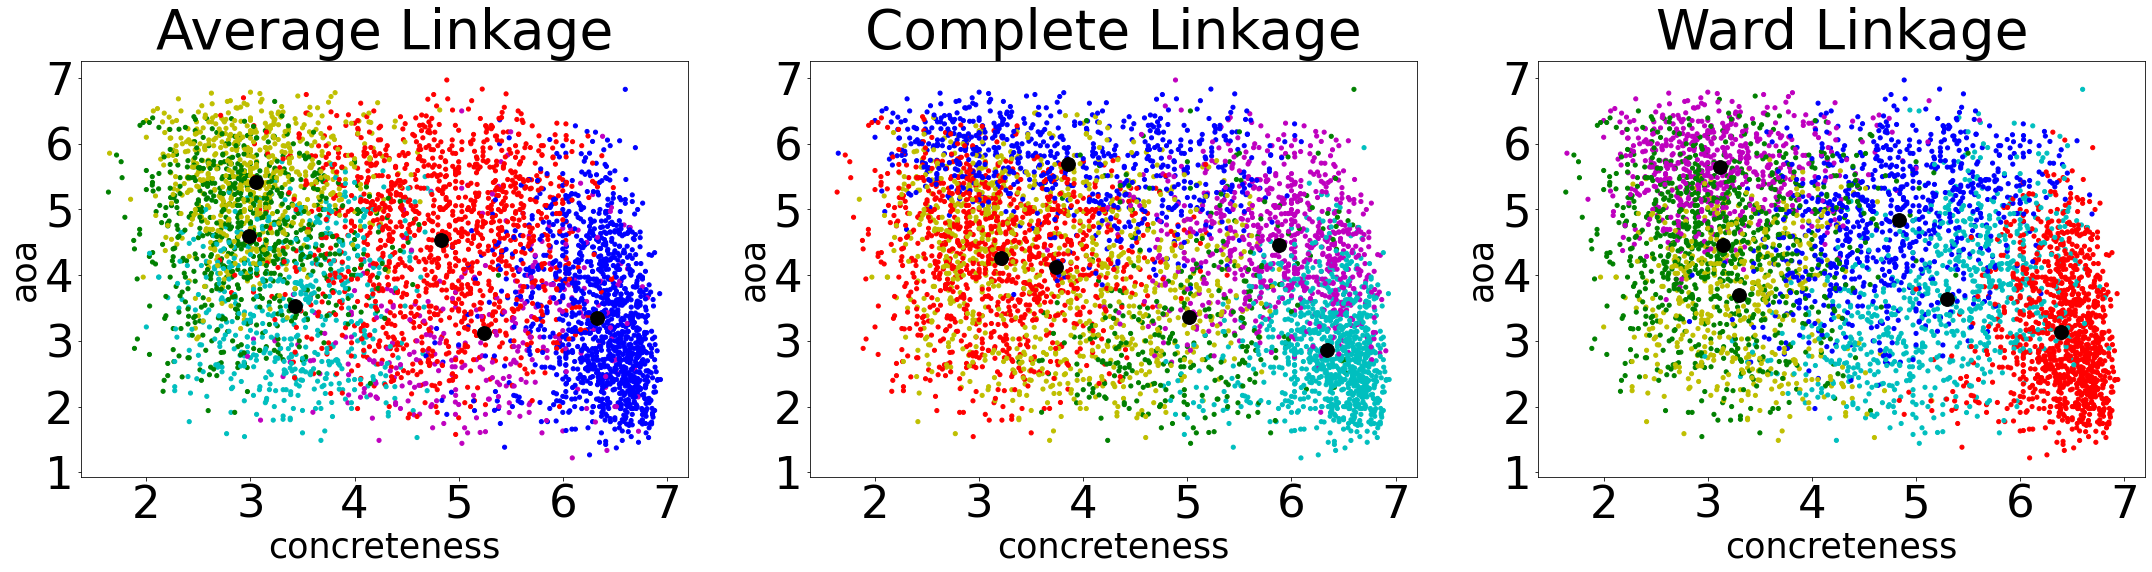

In [30]:
fig = plt.figure(figsize=(37, 26)) 
fig_dims = (3, 3)

hcentroids_dict = {}
list_of_methods = ['average', 'complete', 'ward']

for n, method in enumerate(list_of_methods):
    plt.subplot2grid(fig_dims, (0, n))

    hier = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage=method)
    hier.fit(x_new)

    zz = []
    for x in range(len(list(hier.labels_))):
        if list(hier.labels_)[x] == 0:
            zz.append('r')
        if list(hier.labels_)[x] == 1:
            zz.append('b')
        if list(hier.labels_)[x] == 2:
            zz.append('g')
        if list(hier.labels_)[x] == 3:
            zz.append('y')
        if list(hier.labels_)[x] == 4:
            zz.append('m')
        if list(hier.labels_)[x] == 5:
            zz.append('c')

    df['Clusters_' + method] = hier.labels_

    plt.scatter(df[axis_x], df[axis_y], c=np.array(zz), s=17)
    plt.xlabel(axis_x, fontsize=35)
    plt.ylabel(axis_y, fontsize=35)
    plt.xticks(fontsize=45)
    plt.yticks(fontsize=45)
    plt.title(method[0].upper() + method[1:] + " Linkage", fontsize=55)

    hcentroidi = []

    for i in range(0, len(df['Clusters_' + method].value_counts())):
        xxx = df[axis_x][df['Clusters_' + method] == i]
        yyy = df[axis_y][df['Clusters_' + method] == i]
        xx = sum(xxx)/len(xxx)
        yy = sum(yyy)/len(yyy)
        plt.scatter(xx, yy, c='k', s=190)
        hcentroidi.append((xx, yy, i))
    hcentroids_dict[method] = hcentroidi #this way I store the centroid for each method

The colors may make the differences in linkage criterion a little more comparable I decided to cluster the centroids and assign a unique color to each group of them

In [31]:
centroidi = list()
for key, value in hcentroids_dict.items():
    centroidi += value #I concatenate into a single list of centroids to cluster them
    
centr_array = np.asarray(centroidi)
centr_array

array([[4.83029591, 4.53493344, 0.        ],
       [6.33307449, 3.3484081 , 1.        ],
       [2.98885447, 4.60209222, 2.        ],
       [3.0503907 , 5.41669612, 3.        ],
       [5.23925   , 3.12161667, 4.        ],
       [3.42428164, 3.53845811, 5.        ],
       [3.21459249, 4.25693834, 0.        ],
       [3.85502528, 5.68677528, 1.        ],
       [5.01340129, 3.36827832, 2.        ],
       [3.73531531, 4.12439898, 3.        ],
       [5.88064485, 4.46169777, 4.        ],
       [6.34131027, 2.86014378, 5.        ],
       [6.39454963, 3.13828033, 0.        ],
       [4.83453425, 4.83256413, 1.        ],
       [3.14825739, 4.4613483 , 2.        ],
       [3.29500398, 3.69478728, 3.        ],
       [3.11945222, 5.642     , 4.        ],
       [5.29802788, 3.63324208, 5.        ]])

[0 4 5 1 3 2 5 1 3 2 0 4 4 0 5 2 1 3]


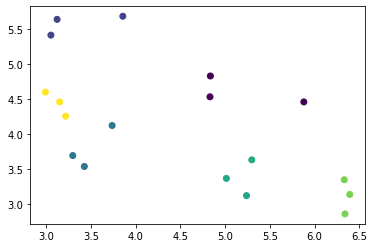

In [32]:
centroid_clustering = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='complete')
centroid_clustering.fit(centr_array[:,:2])
print(centroid_clustering.labels_)
plt.scatter(centr_array[:,0], centr_array[:,1], c=centroid_clustering.labels_)

In [33]:
centr_df = pd.DataFrame(centr_array, columns=('x', 'y', 'original'))
centr_df = centr_df.astype({'original' : int})
centr_df['clustered'] = centroid_clustering.labels_

colori = {}
for k, v in enumerate(['r', 'y', 'c', 'm', 'b', 'g']):
    colori[k] = v

colori_to_pd = [colori.get(number, number) for number in centr_df['clustered']]

centr_df['colori'] = colori_to_pd

centr_df

x         y  original  clustered colori
0   4.830296  4.534933         0          0      r
1   6.333074  3.348408         1          4      b
2   2.988854  4.602092         2          5      g
3   3.050391  5.416696         3          1      y
4   5.239250  3.121617         4          3      m
5   3.424282  3.538458         5          2      c
6   3.214592  4.256938         0          5      g
7   3.855025  5.686775         1          1      y
8   5.013401  3.368278         2          3      m
9   3.735315  4.124399         3          2      c
10  5.880645  4.461698         4          0      r
11  6.341310  2.860144         5          4      b
12  6.394550  3.138280         0          4      b
13  4.834534  4.832564         1          0      r
14  3.148257  4.461348         2          5      g
15  3.295004  3.694787         3          2      c
16  3.119452  5.642000         4          1      y
17  5.298028  3.633242         5          3      m

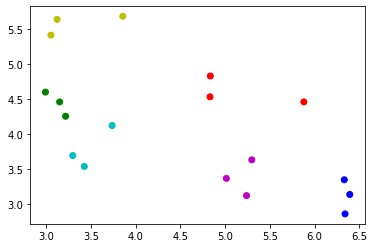

In [34]:
plt.scatter(centr_array[:,0], centr_array[:,1], c=centr_df['colori'])

In [35]:
centroid_average = centr_df[:6].reset_index(drop=True)
centroid_complete = centr_df[6:12].reset_index(drop=True)
centroid_ward = centr_df[12:].reset_index(drop=True)

In [36]:
mapc_average = {}
for i in range(0,6):
    mapc_average[i] = centroid_average['colori'][i]
    
mapc_complete = {}
for i in range(0,6):
    mapc_complete[i] = centroid_complete['colori'][i]

mapc_ward = {}
for i in range(0,6):
    mapc_ward[i] = centroid_ward['colori'][i]
    
print(mapc_average, mapc_complete, mapc_ward, sep='\n')

{0: 'r', 1: 'b', 2: 'g', 3: 'y', 4: 'm', 5: 'c'}
{0: 'g', 1: 'y', 2: 'm', 3: 'c', 4: 'r', 5: 'b'}
{0: 'b', 1: 'r', 2: 'g', 3: 'c', 4: 'y', 5: 'm'}


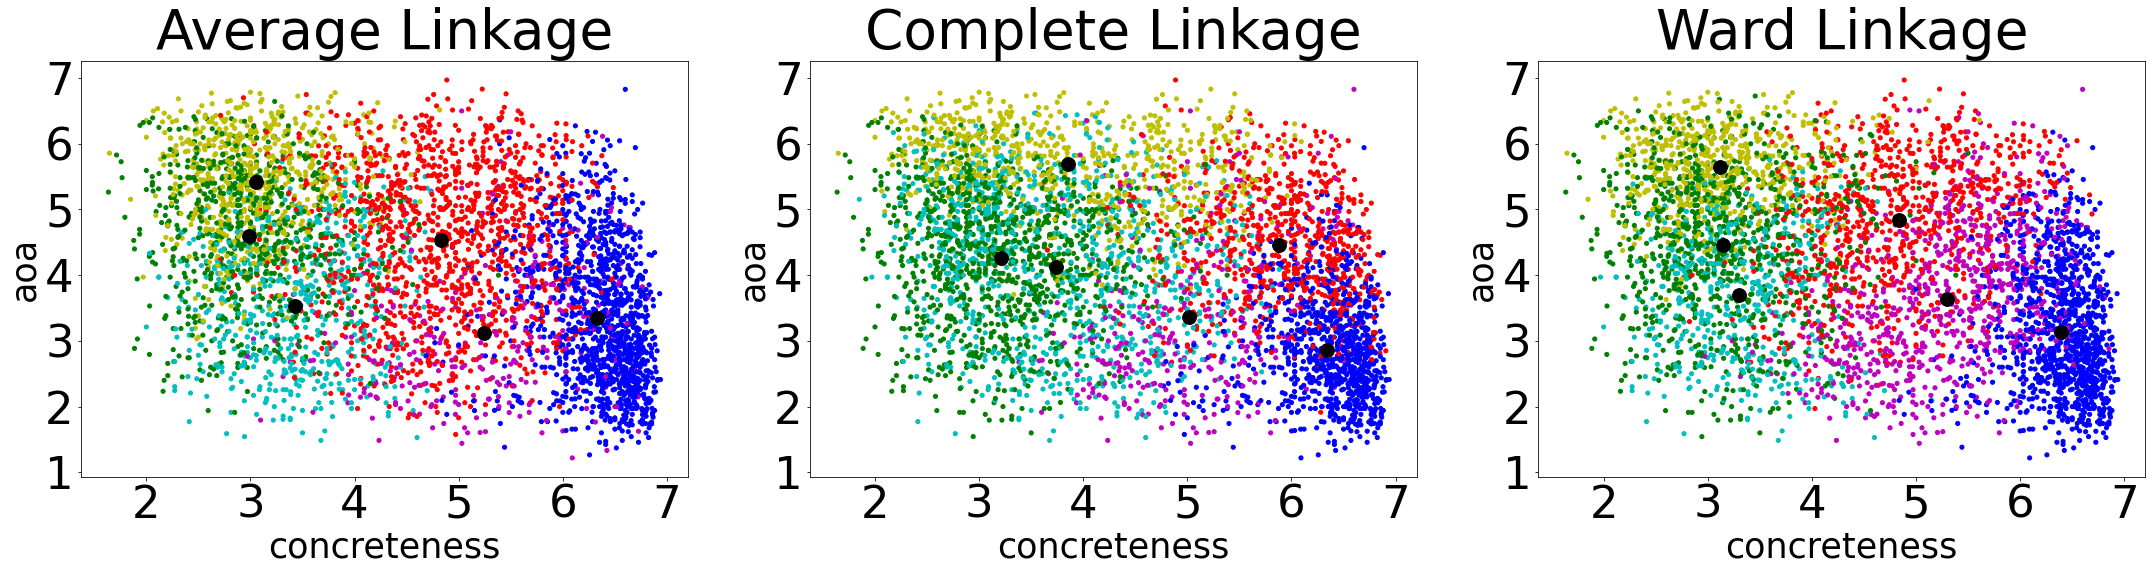

In [37]:
fig = plt.figure(figsize=(37, 26)) 
fig_dims = (3, 3)

methods_n_colors = {(0, 'average') : mapc_average, (1, 'complete') : mapc_complete, (2, 'ward') : mapc_ward}

for key, remap in methods_n_colors.items():
    n = key[0]
    method = key[1]
    
    df['Clusters_'+method] = [remap.get(number, number) for number in df['Clusters_'+method]]
    
    plt.subplot2grid(fig_dims, (0, n))
    plt.scatter(df[axis_x], df[axis_y], c=df['Clusters_'+method], s=17)
    plt.xlabel(axis_x, fontsize=35)
    plt.ylabel(axis_y, fontsize=35)
    plt.xticks(fontsize=45)
    plt.yticks(fontsize=45)
    plt.title(method[0].upper() + method[1:] + " Linkage", fontsize=55)

    for i in df['Clusters_' + method].unique():
        xxx = df[axis_x][df['Clusters_' + method] == i]
        yyy = df[axis_y][df['Clusters_' + method] == i]
        xx = sum(xxx)/len(xxx)
        yy = sum(yyy)/len(yyy)
        plt.scatter(xx, yy, c='k', s=190)

In [38]:
#having selected the average linkage criterion for further inspection I named the clusters
hcluster_name = {'r': 0, 'b': 1, 'g' : 2, 'y' : 3, 'm' : 4, 'c' : 5}
hier_cluster_mapped = [hcluster_name.get(number, number) for number in df['Clusters_average']]
df['avcrit_cluster_name'] = hier_cluster_mapped

In [39]:
average_color = df['Clusters_average']
average_name = df['avcrit_cluster_name']
kmeans_color = df_post_kmeans['eng_color']
kmeans_name = df_post_kmeans['name_cluster']

In [40]:
print("Hierarchical 6 clusters average linkage criterion:")
for col in average_color.unique():
    print(col, 'tot', df_bckp[average_color==col]['polysemy'].count(), 
          '- polysemous count', df_bckp[average_color==col]['polysemy'][df_bckp['polysemy'] == 1].count())

Hierarchical 6 clusters average linkage criterion:
r tot 1247 - polysemous count 125
y tot 645 - polysemous count 11
b tot 1235 - polysemous count 134
g tot 694 - polysemous count 14
c tot 561 - polysemous count 64
m tot 300 - polysemous count 31


In [41]:
SSE = []
for i in range(6):
    cluster_singolo = df[df['avcrit_cluster_name'] == i].drop(columns=(['word', 'length', 'polysemy', 'Clusters_average', 'Clusters_complete', 'Clusters_ward', 'avcrit_cluster_name']))
    sommatoria_di_cluster = []
    for col in cluster_singolo.columns:
        mi = cluster_singolo[col].mean()
        differenza_elevata = []
        for x in cluster_singolo[col]:
            differenza_elevata.append((x - mi)**2)
        sommatoria = sum(differenza_elevata)
        sommatoria_di_cluster.append(sommatoria)
    SSE.append(sommatoria_di_cluster)

SSE = np.asarray(SSE)
SSE_sum_x_features = sum(SSE)
SSE_sum_x_cluster = sum(SSE.T)
SSE_tot = sum(sum(SSE))

df_x_sse = df.drop(columns=['word', 'length', 'polysemy', 'Clusters_average', 'Clusters_complete', 'Clusters_ward'])
cluster_ordinati = []
for i in range(6):
    cluster_ordinati.append(df_x_sse.values[:,-1:][df_x_sse.values[:,-1] == i][0][0])

SSE_df = pd.DataFrame(SSE, columns=([col for col in df_x_sse.columns if col not in ['avcrit_cluster_name']]))
#SSE_df.insert(0, "cluster", [0,1,2,3,4])
SSE_df.insert(0, "cluster", cluster_ordinati)
SSE_df["tot_cluster"] = SSE_sum_x_cluster
SSE_df = SSE_df.append(SSE_df.sum(numeric_only=True), ignore_index=True)
SSE_df_hier = SSE_df.drop(columns=[col for col in SSE_df.columns if col not in ['cluster', 'tot_cluster']])
SSE_df_hier

cluster   tot_cluster
0      0.0  13994.498154
1      1.0  11265.901265
2      2.0   5607.057397
3      3.0   5417.905728
4      4.0   2708.455404
5      5.0   4913.711394
6     15.0  43907.529341

In [42]:
df_post_hierarchical = df.copy(deep=True)
df = df_bckp.copy(deep=True)

<b>Comparison between KMeans and Hierarchical with Average linkage criterion</b></br>
<b>Disclaimer:</b> this is a little bit messier as at each loop I would have had to reassign colors with an iterable but I didn't have time to do it and I've plotted only the correct plots for n_clusters ==5 and 6, for kmeans and hierarchical respectively

In [43]:
average_color = df_post_hierarchical['Clusters_average']
average_name = df_post_hierarchical['avcrit_cluster_name']
kmeans_color = df_post_kmeans['color_map']
kmeans_name = df_post_kmeans['name_cluster']

For n_clusters = 2 The average silhouette_score is : 0.36482613822968585
For n_clusters = 3 The average silhouette_score is : 0.3467430831484627
For n_clusters = 4 The average silhouette_score is : 0.30217593412099525
For n_clusters = 5 The average silhouette_score is : 0.3043286439408455
For n_clusters = 6 The average silhouette_score is : 0.28974589444202187


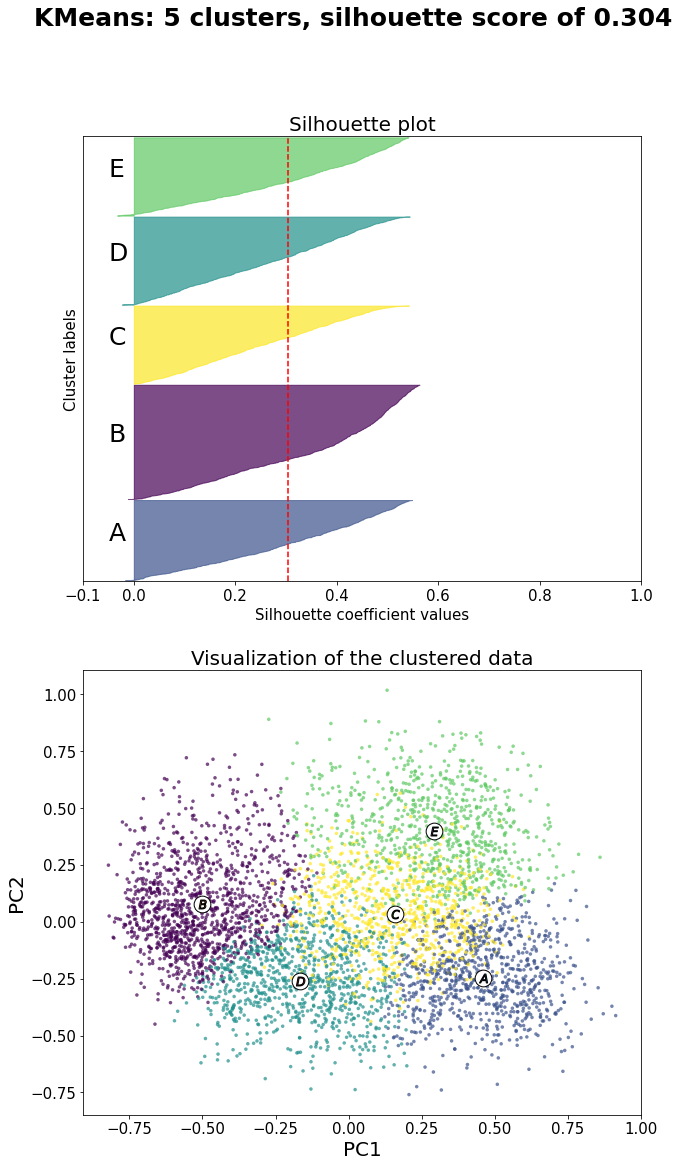

In [44]:
#I fixed the colors only for n_clusters == 5 because I wanted to plot them in the final report

X = df_pca.values
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
    
X = df_pca.values
range_n_clusters = [5]

#rinomina cluster
dizionario_cluster = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F"}
colori = {0: "#fde725", 1: "#5ec962", 2: "#3b528b", 3: "#21918c", 4: "#440154", 5: "#ff0000"}
colori = {0: (253.0, 231.0, 37.0, 1.0), 1: (94.0, 201.0, 98.0, 1.0), 2: (59.0, 82.0, 139.0, 1.0), 
          3: (33.0, 145.0, 140.0, 1.0), 4: (68.0, 1.0, 84.0, 1.0), 5: (255.0, 0.0, 0.0, 1.0)}
colori = {0: (59.0, 82.0, 139.0, 1.0), 1: (68.0, 1.0, 84.0, 1.0), 2: (253.0, 231.0, 37.0, 1.0), 
          3: (33.0, 145.0, 140.0, 1.0), 4: (94.0, 201.0, 98.0, 1.0), 5: (255.0, 0.0, 0.0, 1.0)}

colori = np.asarray([x for x in colori.values()]) / 256

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(10, 18)

    # Silhouette plot excluding values lower -0.1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to mark them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each cluster
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=colori[i],
            edgecolor=colori[i],
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, dizionario_cluster[i], fontsize = 25)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot", fontsize=20)
    ax1.set_xlabel("Silhouette coefficient values", fontsize=15)
    ax1.set_ylabel("Cluster labels", fontsize=15)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis='both', which='major', labelsize=15)

    # 2nd Plot showing the actual clusters
    if n_clusters == 5:
        ax2.scatter(X[:, 0], X[:, 1], marker=".", s=50, lw=0, alpha=0.7, c=kmeans_color, edgecolor="k")
    else:
        ax2.scatter(X[:, 0], X[:, 1], marker=".", s=50, lw=0, alpha=0.7, c=cluster_labels, edgecolor="k")

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=280,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        if n_clusters != 5:
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
        else:
            ax2.scatter(c[0], c[1], marker="$%s$" % dizionario_cluster[i], alpha=1, s=80, edgecolor="k")

    ax2.set_title("Visualization of the clustered data", fontsize=20)
    ax2.set_xlabel("PC1", fontsize=20)
    ax2.set_ylabel("PC2", fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=15)

    plt.suptitle(
        "KMeans: {} clusters, silhouette score of {}".format(n_clusters, round(silhouette_avg, 3)),
        fontsize=25,
        fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.310936539446625
For n_clusters = 3 The average silhouette_score is : 0.25177803392273057
For n_clusters = 4 The average silhouette_score is : 0.21681076278513015
For n_clusters = 5 The average silhouette_score is : 0.2035636753926616
For n_clusters = 6 The average silhouette_score is : 0.2085131624056743


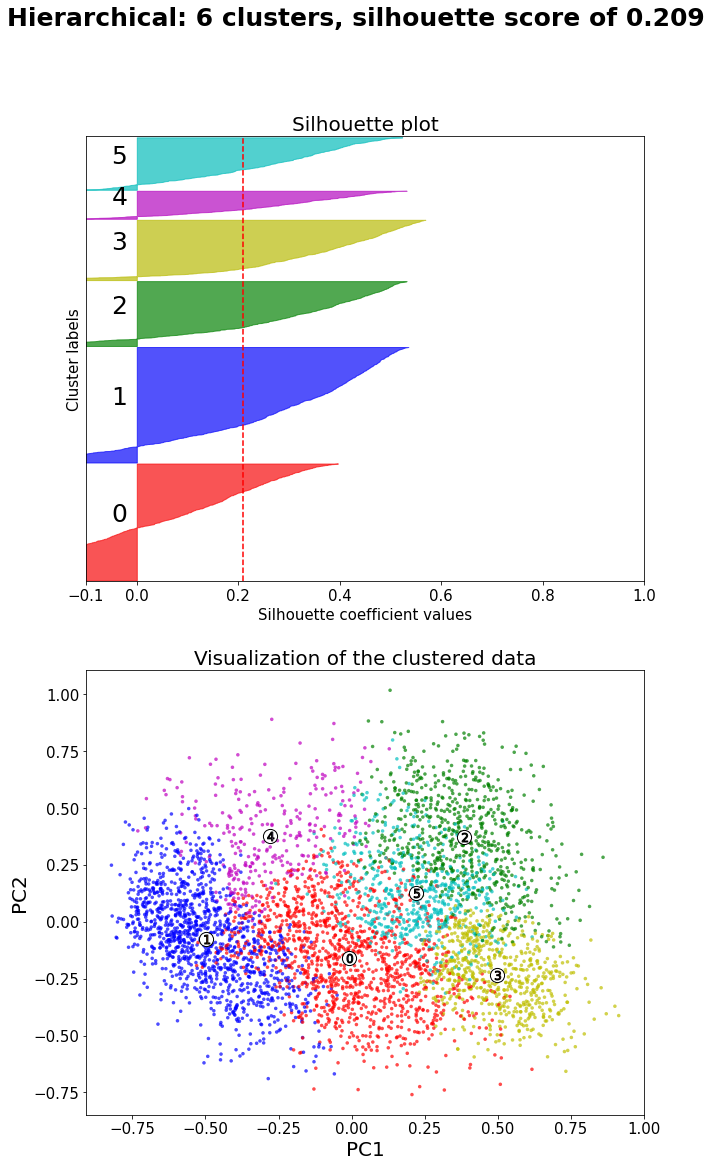

In [45]:
#I fixed the colors only for n_clusters == 6 because I wanted to plot them in the final report

X = df_pca.values
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='average')
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)
X = df_pca.values

range_n_clusters = [6]

colori = {0: (248, 12, 13, 1), 1: (8, 8, 251, 1), 2: (7, 133, 7, 1), 
          3: (186, 188, 8, 1), 4: (181, 10, 192, 1), 5: (8, 189, 188, 1)}

colori = np.asarray([x for x in colori.values()]) / 256

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.set_size_inches(10, 18)

    # Silhouette plot excluding values lower -0.1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to mark them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='average')
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each cluster
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=colori[i],
            edgecolor=colori[i],
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, i, fontsize = 25)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette plot", fontsize=20)
    ax1.set_xlabel("Silhouette coefficient values", fontsize=15)
    ax1.set_ylabel("Cluster labels", fontsize=15)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(axis='both', which='major', labelsize=15)

    # 2nd Plot showing the actual clusters
    if n_clusters == 6:
        ax2.scatter(X[:, 0], X[:, 1], marker=".", s=50, lw=0, alpha=0.7, c=average_color, edgecolor="k")
    else:
        ax2.scatter(X[:, 0], X[:, 1], marker=".", s=50, lw=0, alpha=0.7, c=cluster_labels, edgecolor="k")

    # Labeling the clusters
    centers = pd.DataFrame(columns = [0,1,2])
    for x in range(0, n_clusters):
        centers = centers.T
        centers[str(x)] = pd.DataFrame(X)[clusterer.labels_ == x].mean()
        centers = centers.T
    centers = centers.values
    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        if n_clusters != 6:
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
        else:
            ax2.scatter(c[0], c[1], marker="$%s$" % i, alpha=1, s=80, edgecolor="k")

    ax2.set_title("Visualization of the clustered data", fontsize=20)
    ax2.set_xlabel("PC1", fontsize=20)
    ax2.set_ylabel("PC2", fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=15)

    plt.suptitle(
        "Hierarchical: {} clusters, silhouette score of {}".format(n_clusters, round(silhouette_avg, 3)),
        fontsize=25,
        fontweight="bold",
    )

plt.show()